In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/조인설/class 50

import time
import numpy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from keras.utils import to_categorical


time_periods = 20 #frame
number_sensors = 84 #keypoint
input_shape = (time_periods * number_sensors)

# Load CSV dataset with X (training data) and Y (label)
raw_dataset = numpy.loadtxt("HAND_ALL_50_AUG_OneRow.csv", delimiter = ",") 
X = raw_dataset[:, 0:1680] # 양손 keypoint값
y = raw_dataset[:, 1680] # class label
transformer = Normalizer().fit(X)

X = transformer.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print(y_train)

/content/drive/MyDrive/조인설/class 50
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


하나의 라벨은 42개의 keypoint * 20개의 frame

time step : 20
features : 42

In [4]:
print(X_train.shape[0])
print(X_test.shape[0])

6656
1664


In [5]:
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM
from keras.models import Sequential
from keras.layers import Dense, InputLayer, Dropout, Flatten, Activation, Reshape
from keras import optimizers

model = Sequential() # Sequeatial Model
model.add(Reshape((time_periods, number_sensors), input_shape=(input_shape,)))
model.add(Bidirectional(LSTM(80, return_sequences=True))) # (timestep, feature)
model.add(Bidirectional(LSTM(40, return_sequences=True)))
model.add(Flatten())
model.add(Dense(512, activation = "relu"))
model.add(Dense(50, activation = "softmax")) # output = 50
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 20, 84)            0         
                                                                 
 bidirectional (Bidirectiona  (None, 20, 160)          105600    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 20, 80)           64320     
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 512)               819712    
                                                                 
 dense_1 (Dense)             (None, 50)                2

In [7]:
model.fit(X_train, y_train, epochs=100, batch_size=16)

Epoch 1/100
416/416 [==============================] - 17s 14ms/step - loss: 3.0309 - accuracy: 0.1451
Epoch 2/100
416/416 [==============================] - 5s 11ms/step - loss: 1.8587 - accuracy: 0.3888
Epoch 3/100
416/416 [==============================] - 7s 16ms/step - loss: 1.4319 - accuracy: 0.5102
Epoch 4/100
416/416 [==============================] - 7s 18ms/step - loss: 1.1219 - accuracy: 0.6124
Epoch 5/100
416/416 [==============================] - 5s 11ms/step - loss: 0.9219 - accuracy: 0.6786
Epoch 6/100
416/416 [==============================] - 7s 16ms/step - loss: 0.7473 - accuracy: 0.7395
Epoch 7/100
416/416 [==============================] - 5s 12ms/step - loss: 0.5883 - accuracy: 0.7895
Epoch 8/100
416/416 [==============================] - 5s 11ms/step - loss: 0.5132 - accuracy: 0.8155
Epoch 9/100
416/416 [==============================] - 5s 12ms/step - loss: 0.4160 - accuracy: 0.8520
Epoch 10/100
416/416 [==============================] - 5s 11ms/step - loss: 0.35

In [10]:
test_loss, test_acc = model.evaluate(X_test, y_test)
loss_and_metrics = model.evaluate(X_test, y_test, batch_size=16, verbose = 0)
print("Score: ", loss_and_metrics)

52/52 [==============================] - 2s 6ms/step - loss: 0.1887 - accuracy: 0.9790
Score:  [0.18872642517089844, 0.9789663553237915]


In [11]:
import numpy as np
y_pred = model.predict(X_test)
predicted = y_pred.argmax(axis=-1)
y_labels = y_test.argmax(axis=-1)

52/52 [==============================] - 1s 5ms/step


In [12]:
def plt_confusion_matrix(cm, labels, title):
    # Makes everything blue, which is my favorite color
    cmap = plt.cm.Blues

    # Define the plot
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    # Define the labels on the matrix display
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=labels,
           yticklabels=labels,
           title=title,
           ylabel='True',
           xlabel='Predicted')

    # Add values of confusion matrix to the plot
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    #file_name = "Confusion_Matrices/Confusion-Matrix-" + str(fold_no) + ".png"
    #plt.savefig(file_name)
    #plt.close()
    plt.show()

In [13]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(y_labels, predicted)
print(cm)

[[39  0  0 ...  0  0  0]
 [ 0 57  0 ...  0  0  0]
 [ 0  0 38 ...  0  0  0]
 ...
 [ 0  0  0 ... 41  0  0]
 [ 0  0  0 ...  0 25  0]
 [ 0  0  0 ...  0  0 21]]


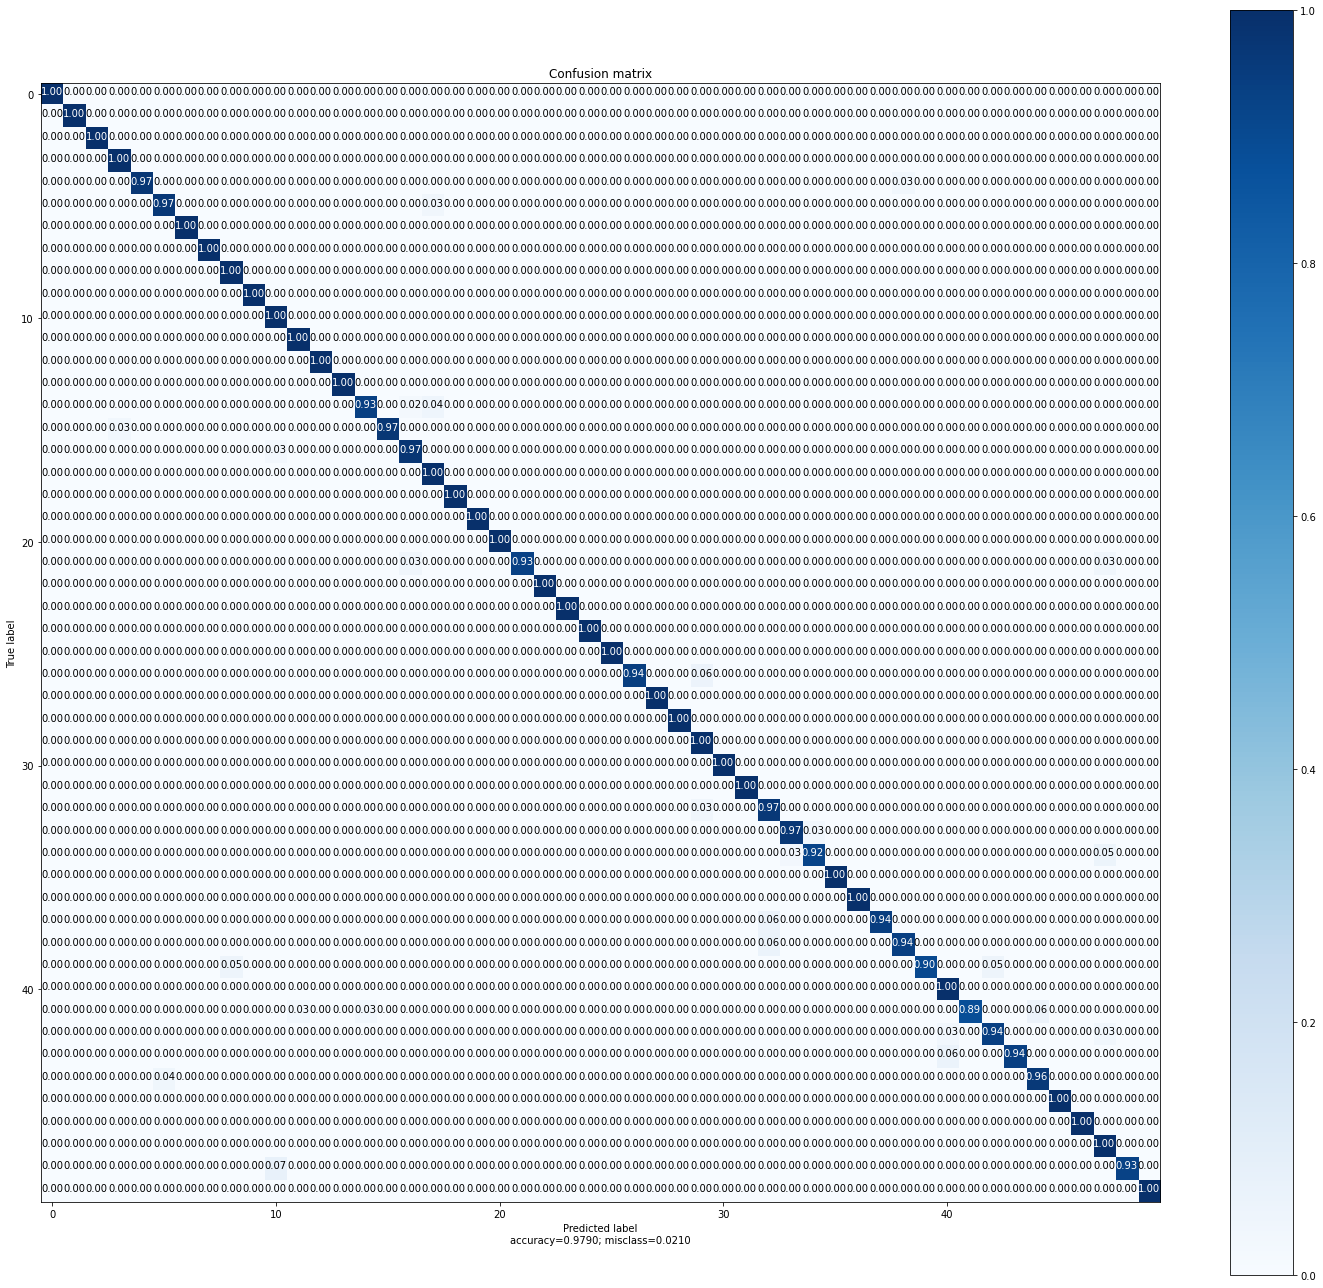

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import itertools
from itertools import product

def plot_confusion_matrix(cm, target_names=None, cmap=None, normalize=True, labels=True, title='Confusion matrix'):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.figure(figsize=(20, 18))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)
    
    if labels:
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            if normalize:
                plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")
            else:
                plt.text(j, i, "{:,}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

p= plot_confusion_matrix(cm)

In [17]:
%cd /content/drive/MyDrive/조인설/class 50

model.save("model_50.h5")

/content/drive/MyDrive/조인설/class 50
